# Демонстрация автоматического расчета PDP

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pylab as pl

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PlotPDP, base_pipe

In [4]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab
import pdpbox

print('pandas: ', pd.__version__)
print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)
print('pdpbox: ', pdpbox.__version__)

pandas:  1.3.5
sklearn:  1.0.2
xgboost:  1.5.2
matplotlib:  3.5.1
autobinary:  1.0.7
pdpbox:  0.2.0


In [5]:
sample = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены количественные и категориальные переменные!


In [9]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [10]:
# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(
    eta=0.01,
    n_estimators=800,
    subsample=0.9,
    colsample_bytree=0.6,
    max_depth = 6,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [11]:
xgb_model.fit(new_X_train, y_train);

[16:29:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## 1. Использование библиотеки PDP

In [12]:
# Задаем необходимые факторы для анализа, в нужном нам порядке

feats = ['Age','Fare', 'Sex', 'Pclass']

In [13]:
# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=xgb_model,X=new_X_train,main_features=feats)

Age


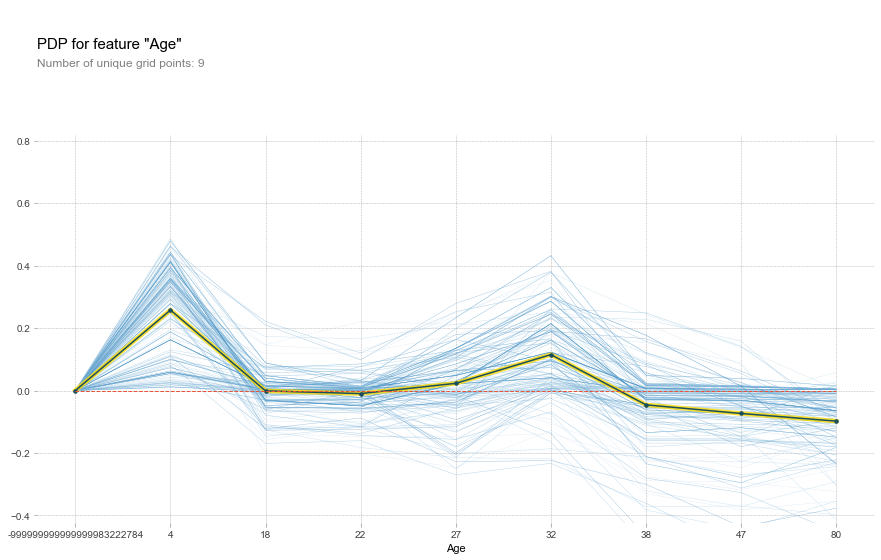

Fare


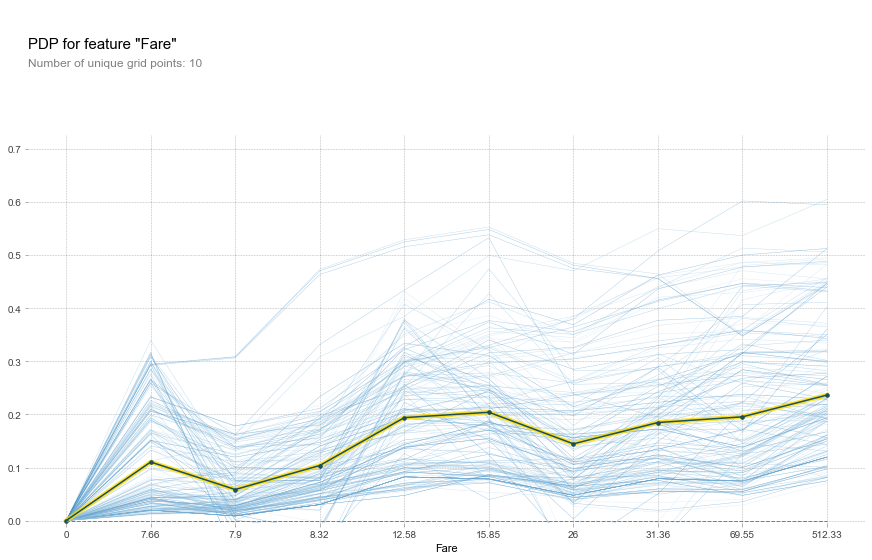

Sex


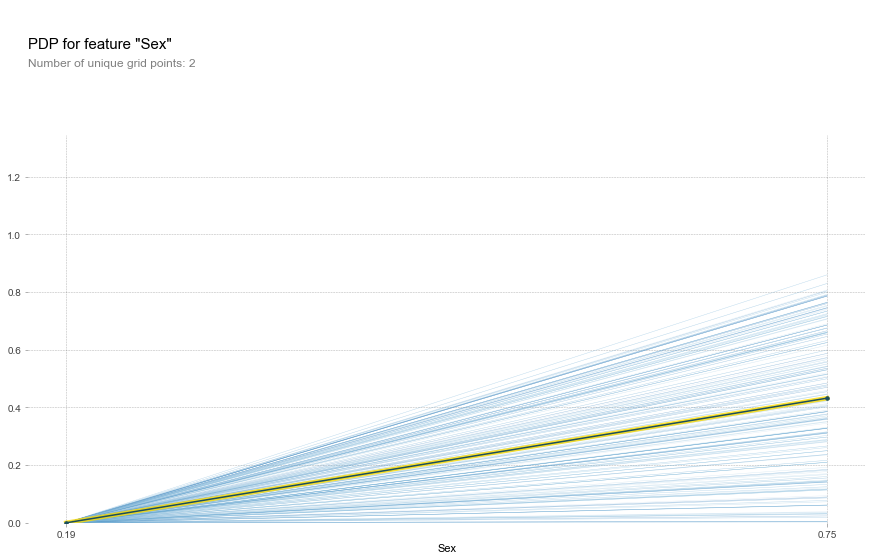

Pclass


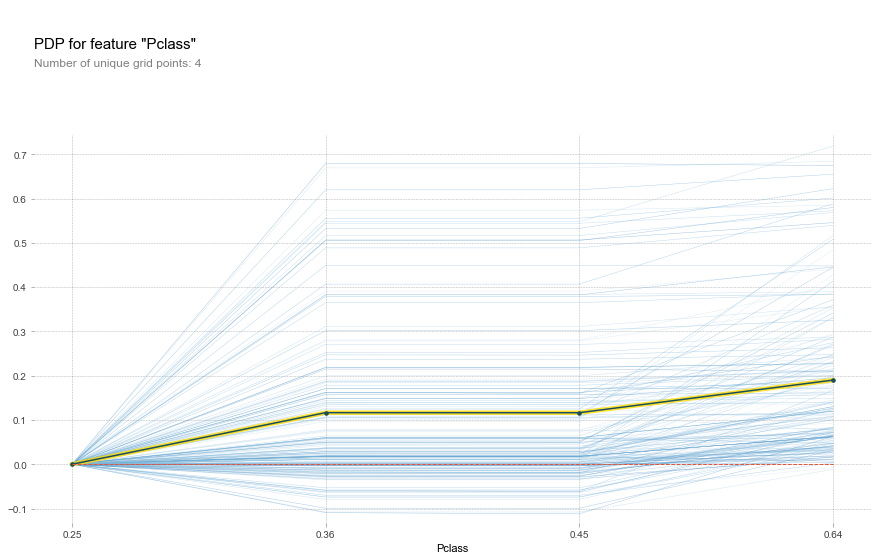

In [14]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Age', 'Fare'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


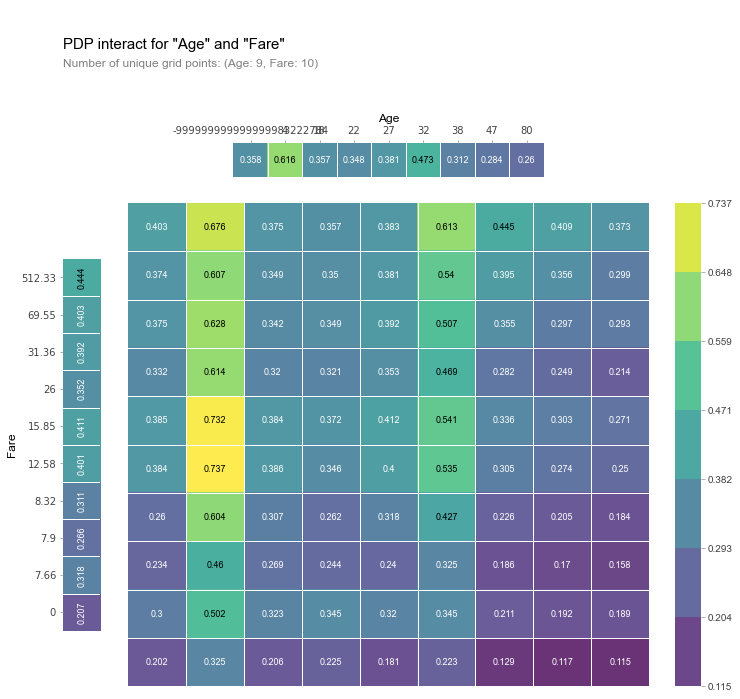

In [15]:
pdp_plot.create_interact_plot(features=['Age','Fare'], save=True)

In [16]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.
